# Ejercicio 8 - guia 9

Realizar un ajuste usando PyMC de un GLM de la práctica 4. Graficar la posterior de los parámetros. Graficar los datos y el HDI de la posterior predictive.

### Desarrollo

Para este caso decidí ajustar el GLM propuesto en el **[ejercicio 7 de la guía 4](../guia_4/ejercicio_7_guia.ipynb)**. Por lo tanto paso a cargar los datos 
de dicho ejercicio:

In [1]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

ruta_datos_nambe = os.path.join('..', '..','datos', 'raw' ,'nambeware.csv')

df_nambe = pd.read_csv(ruta_datos_nambe, index_col=0)

df_nambe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 58
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Type    59 non-null     object 
 1   Diam    59 non-null     float64
 2   Time    59 non-null     float64
 3   Price   59 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.3+ KB


Hago un gráfico para recordar como se relacionaba la variable objetivo respecto de la predictora:

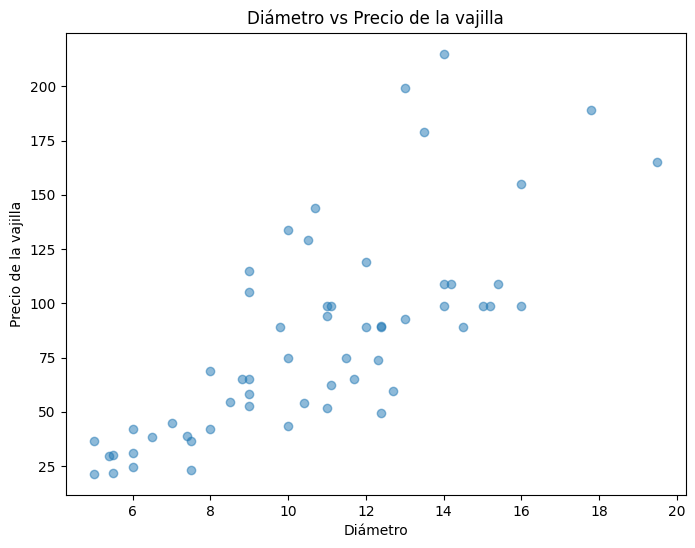

In [3]:
import matplotlib.pyplot as plt


# Elimino outliers
df_nambe = df_nambe[df_nambe['Diam'] < 20]

plt.figure(figsize=(8, 6))
plt.scatter(df_nambe['Diam'], df_nambe['Price'], alpha=0.5)
plt.xlabel('Diámetro')
plt.ylabel('Precio de la vajilla')
plt.title('Diámetro vs Precio de la vajilla')
plt.show()

Antes de generar el modelo hay que pensar un par de cosas respecto de estas variables:

* Queremos modelar **el precio de la vajilla en función de su diámetro**, evidentemente precio y díametro son cosas que **toman valores positivos** 

* Considerando esto de los valores positivos, primero debemos pensar en el parámetro **B0** el cual representa el promedio del precio de una vajilla, a ese 
  como no tenemos información previa más que su promedio, podríamos modelarlo con una distribución normal centrada en dicho promedio según los datos que tenemos

* Luego, pensando en el parámetro **B1**, el cual representa la relación precio/diámetro, por lo visto en el gráfico podemos decir que es una relación 
  **positiva y ascendente**, y que además que por cada 2 centímetros de díametro en la vajilla, hay un cambio de 25$ más en el precio final, por lo tanto
   la relación es **25/2**. Como queremos mantener este parámetro positivo, modelaré su prior con una distribución **HalfNormal con desviación igual a 25/2**

Paso a mostrar la media de cada prior:

In [16]:
media_precio = df_nambe['Price'].mean()
media_relacion_precio_diametro = 25/2 # Observado del gráfico

print(f'El precio promedio de las vajillas (B0) es de {media_precio:.2f}')
print(f'La relación precio/diámetro (B1) es de {media_relacion_precio_diametro:.2f}')

El precio promedio de las vajillas (B0) es de 83.39
La relación precio/diámetro (B1) es de 12.50


Ahora con todo explicado, paso a ajustar el modelo con PyMC:

In [20]:
import pymc as pm

X = df_nambe['Diam'].values.flatten()
Y = df_nambe['Price'].values.flatten()

with pm.Model() as modelo_nambe:

    # Defino distribuciones de los priors
    B0 = pm.Normal('B0', mu=media_precio, sigma=5)
    B1 = pm.HalfNormal('B1', sigma=media_relacion_precio_diametro) # Lo quiero mantener positivo (que la historia me juzgue)
    alpha = pm.HalfNormal('alpha', sigma=10)
    
    # Armo la función de enlace
    mu = B0 + B1 * X
    func_enlace = 1/mu # VER PORQUE NO ES -1/mu, error con pymc

    # Armo la likelihood
    y_obs = pm.Gamma('y_obs', alpha=alpha, beta=func_enlace, observed=Y)

    # Obtengo la traza
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B0, B1, alpha]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 161 seconds.


Y ahora paso a apreciar los resultados del modelo:

In [21]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
B0,77.634,5.166,68.216,87.387,0.083,0.058,3917.0,4355.0,1.0
B1,0.623,0.604,0.000,1.741,0.010,0.007,2995.0,2215.0,1.0
alpha,1.317,0.149,1.028,1.594,0.002,0.002,3821.0,3697.0,1.0


<Figure size 800x500 with 0 Axes>

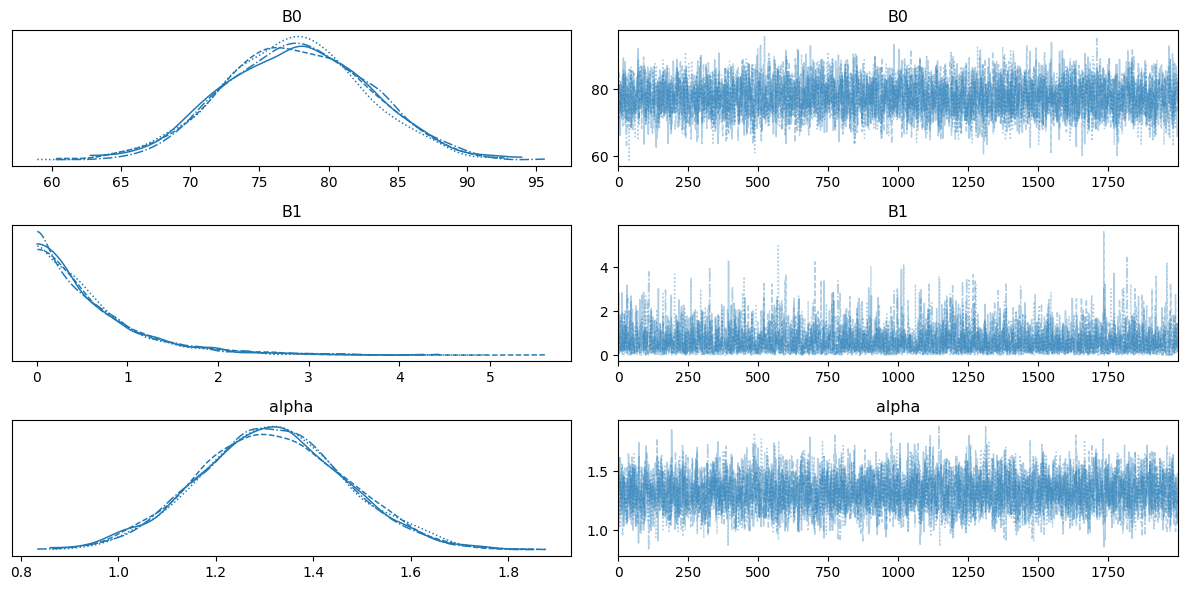

In [22]:
plt.figure(figsize=(8, 5))
pm.plot_trace(trace)
plt.tight_layout()
plt.show()

Finalmente grafico el 90% HDI de la posterior predictive:

Sampling: [B0, B1, alpha, y_obs]
Sampling: [y_obs]


Output()

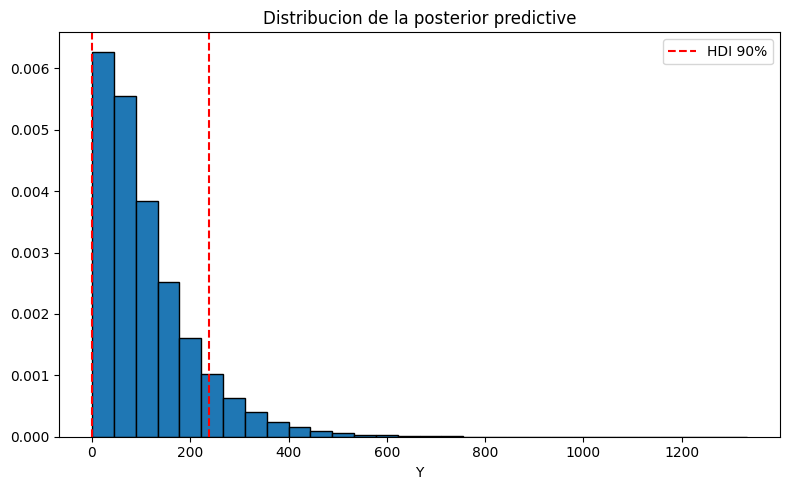

In [23]:
import arviz as az

with modelo_nambe:
    trace.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    
estimaciones_y = trace.posterior_predictive['y_obs'].values.flatten()
hdi_90_y = az.hdi(estimaciones_y, hdi_prob=0.9)

plt.figure(figsize=(8, 5))
plt.hist(estimaciones_y, bins=30, density=True, edgecolor='black')
plt.title('Distribucion de la posterior predictive')
plt.axvline(hdi_90_y[0], color='red', linestyle='--', label='HDI 90%')
plt.axvline(hdi_90_y[1], color='red', linestyle='--')
plt.xlabel('Y')
plt.legend()
plt.tight_layout()
plt.show()